# Geokr

## Initialize

In [1]:
import json
from flickr import Flickr

with open('.config') as fp:
    config = json.load(fp)

flickr = Flickr(config['API_KEY'])

# Localization

## Get photos

In [2]:
geoLocalized = [photo for photo in flickr.loadDataFromFile('data15000JustGeo.json') if photo["latitude"] != 0 and photo["longitude"] != 0]

## Get the coordinates from data

In [3]:
import numpy as np

coordinates = [[photo["latitude"], photo["longitude"]] for photo in geoLocalized]

print "%d images localisées" % len(coordinates)

coordinates = np.array(coordinates, dtype=float)

14956 images localisées


## DBSCAN

In [4]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=10,min_samples=40).fit(coordinates)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print 'Estimated number of clusters: %d' % n_clusters_
print "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(coordinates, db.labels_)

Estimated number of clusters: 7
Silhouette Coefficient: 0.051


### Plot

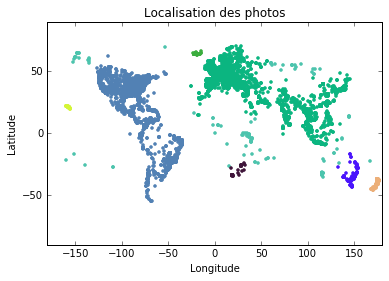

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

colors = [np.random.rand(3,1) for i in range(n_clusters_+1)]

fig, ax = plt.subplots()
ax.set_xlim((-180.0, 180.0))
ax.set_ylim((-90.0, 90.0))

i = 0
for label in db.labels_:
    ax.plot(coordinates[i][1], coordinates[i][0], marker='.', c=colors[(label+1)])
    i += 1

plt.title('Localisation des photos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
    
plt.show()

## KMeans

### Run the algorithm

In [6]:
from scipy.cluster.vq import kmeans2

k = 15
i = 1200

centroids, closest_centroids = kmeans2(coordinates, k, iter=i)

centroids = [centroids[i] for i in range(len(centroids)) if i in set(closest_centroids)]

print "%d centroids" % len(centroids)

15 centroids


### Plot

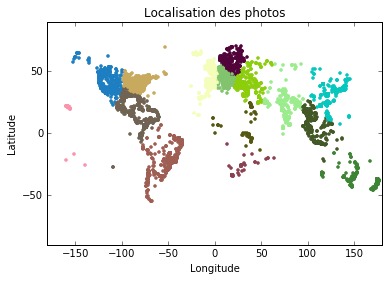

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

colors = [np.random.rand(3,1) for c in range(len(centroids)+1)]

fig, ax = plt.subplots()
ax.set_xlim((-180.0, 180.0))
ax.set_ylim((-90.0, 90.0))

for i in range(len(coordinates)):
    ax.plot(coordinates[i][1], coordinates[i][0], marker='.', c=colors[closest_centroids[i]])

plt.title('Localisation des photos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

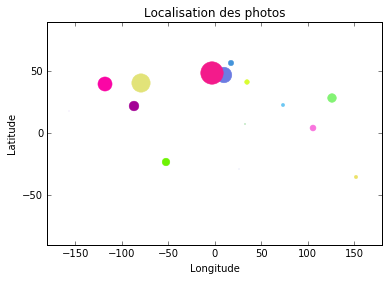

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

colors = [np.random.rand(3,1) for i in range(len(centroids))]

fig, ax = plt.subplots()
ax.set_xlim((-180.0, 180.0))
ax.set_ylim((-90.0, 90.0))

weight = [float(len([c for c in closest_centroids if c == i])) for i in range(len(centroids))]
weight = [w*len(centroids)*3/max(weight) for w in weight]

for i in range(len(centroids)):
    ax.plot(centroids[i][1], centroids[i][0], c=colors[i], marker='.', markersize=weight[i])

plt.title('Localisation des photos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### Map

In [9]:
import folium
from IPython.display import HTML

def inline_map(m, width=800, height=600):
    """Takes a folium instance and embed HTML."""
    
    srcdoc = m._repr_html_().replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed


width, height = 800, 600
radars = folium.Map(location=[40, -122], zoom_start=1,
                    tiles='OpenStreetMap', width=width, height=height)

for centroid in centroids:
    folium.Marker([centroid[0], centroid[1]], ).add_to(radars) 

inline_map(radars)

# Format des images

## Ges photos

In [10]:
fullSet = flickr.loadDataFromFile('dataTest.json')

## Plot

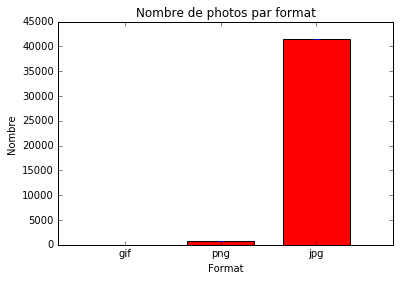

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

groups = set([p['originalformat'] for p in fullSet if p.has_key('originalformat') ])
groups = tuple(groups)
means = [len([p for p in fullSet if p.has_key('originalformat') and p['originalformat'] in group]) for group in groups]
means = tuple(means)
N = len(groups)

ind = np.arange(N)  # the x locations for the groups
width = 0.7       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar([i+width/2 for i in ind], means, width, color='r', yerr=range(N))

# add some text for labels, title and axes ticks
ax.set_xlabel('Format')
ax.set_ylabel('Nombre')
ax.set_title('Nombre de photos par format')
ax.set_xticks(ind + width)
ax.set_xticklabels(groups)

plt.show()

# Dimensions

## Get photos datas

In [12]:
fullSet = flickr.loadDataFromFile('dataTest.json')

dimensions = [[float(photo['o_width']), float(photo['o_height'])] for photo in fullSet if photo.has_key('o_width') and photo.has_key('o_height') and photo['o_width'] != 0 and photo['o_height'] != 0]

## Plots

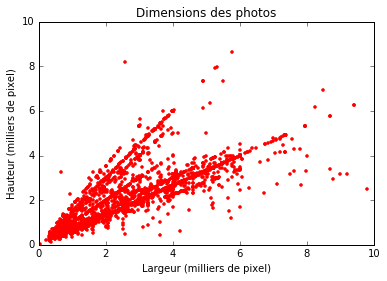

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_xlim((0.0, 10))
ax.set_ylim((0.0, 10))

ax.set_xlabel('Largeur (milliers de pixel)')
ax.set_ylabel('Hauteur (milliers de pixel)')
ax.set_title('Dimensions des photos')

for dimension in dimensions:
    ax.plot(dimension[0]/1000, dimension[1]/1000, c='r', marker='.')

plt.show()

## Sort dimensions to avoid portait format

In [14]:
from scipy.cluster.vq import kmeans2

sortedDimensions = []
for dim in dimensions:
    if dim[0] > dim[1]:
        sortedDimensions += [dim]
    else:
        sortedDimensions += [(dim[1],dim[0])]

print "%d dimensions" % len(dimensions)
#print "%d centroids" % len(centroids)

5268 dimensions


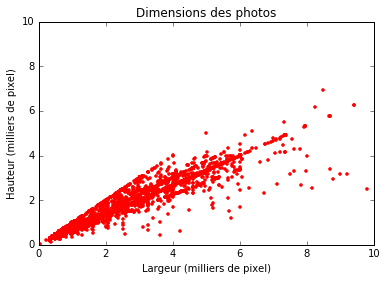

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_xlim((0.0, 10))
ax.set_ylim((0.0, 10))

ax.set_xlabel('Largeur (milliers de pixel)')
ax.set_ylabel('Hauteur (milliers de pixel)')
ax.set_title('Dimensions des photos')

for dimension in sortedDimensions:
    ax.plot(dimension[0]/1000, dimension[1]/1000, c='r', marker='.')

plt.show()

## KMeans

In [16]:
from scipy.cluster.vq import kmeans2

k = 10
i = 1000

centroids, closest_centroids = kmeans2(sortedDimensions, k, iter=i)

centroids = [centroids[i] for i in range(len(centroids)) if i in set(closest_centroids)]

nbPhotosPerCentroids = [len([c for c in closest_centroids if c == i]) for i in range(len(centroids))]

print "%d dimensions" % len(sortedDimensions)
print "%d centroids" % len(centroids)

5268 dimensions
10 centroids


### Plot

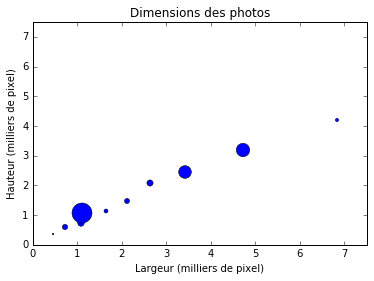

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

m = max([c[1] for c in centroids] + [c[0] for c in centroids])/1000

weight = [float(n)*len(centroids)*2/max(nbPhotosPerCentroids) for n in nbPhotosPerCentroids]

fig, ax = plt.subplots()

ax.set_xlim((0.0, m*1.1))
ax.set_ylim((0.0, m*1.1))

ax.set_xlabel('Largeur (milliers de pixel)')
ax.set_ylabel('Hauteur (milliers de pixel)')
ax.set_title('Dimensions des photos')

for i in range(len(centroids)):
    ax.plot(centroids[i][0]/1000, centroids[i][1]/1000, c='b', marker='o', markersize=weight[i])

plt.show()

# Definitions

## Calc and count

In [18]:
from operator import itemgetter, attrgetter, methodcaller

def getPixelNumber(photo):
    return float(photo['o_width'])*int(photo['o_height'])

dimensionnedPhotos = [photo for photo in fullSet if photo.has_key('o_width') and photo.has_key('o_height') and photo['o_width'] != 0 and photo['o_height'] != 0]
resolutions = [getPixelNumber(photo) for photo in dimensionnedPhotos if getPixelNumber(photo)]
resolutions.sort()

## KMeans

In [19]:
from scipy.cluster.vq import kmeans2

k = 6
i = 1000

centroids, closest_centroids = kmeans2(resolutions, k, iter=i)

centroids = [centroids[i] for i in range(len(centroids)) if i in set(closest_centroids)]

nbPhotosPerCentroids = [len([c for c in closest_centroids if c == i]) for i in range(len(centroids))]

print "%d dimensions" % len(resolutions)
print "%d centroids" % len(centroids)

5268 dimensions
6 centroids


## Plots

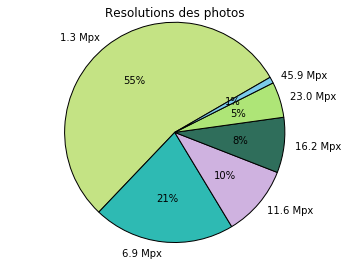

In [20]:
import matplotlib.pyplot as plt

nbSlice = 7

means = [(float(int(centroids[i]*10/(1000**2)))/10,nbPhotosPerCentroids[i]) for i in range(len(centroids))]
means = sorted(means, key=itemgetter(0))
means = [(str(m[0]) + " Mpx", m[1]) for m in means]

if nbSlice < len(centroids):
    means = [(m[0],m[1]) for m in means[:nbSlice]] + [('Autre', sum([m[1] for m in means[nbSlice:]]))]

# The slices will be ordered and plotted counter-clockwise.
labels = [m[0] for m in means]
sizes = [m[1] for m in means]
colors = [np.random.rand(3,1) for i in range(len(means))]

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.0f%%', startangle=30)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

plt.title('Resolutions des photos')

plt.show()

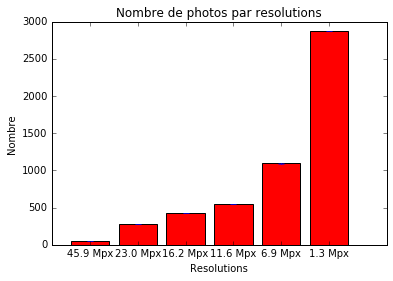

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt

nbBar = len(centroids)

means = [(float(int(centroids[i]*10/(1000**2)))/10,nbPhotosPerCentroids[i]) for i in range(len(centroids))]
means = sorted(means, key=itemgetter(1))[::-1]
means = [(str(m[0]) + " Mpx", m[1]) for m in means[:nbBar][::-1]]

groups = [m[0] for m in means]

means = [m[1] for m in means]
means = tuple(means)

N = nbBar

ind = np.arange(N)  # the x locations for the groups
width = 0.8       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar([i+width/2 for i in ind], means, width, color='r', yerr=range(N))

# add some text for labels, title and axes ticks
ax.set_xlabel('Resolutions')
ax.set_ylabel('Nombre')
ax.set_title('Nombre de photos par resolutions')
ax.set_xticks(ind + width)
ax.set_xticklabels(groups)

plt.show()